<a href="https://colab.research.google.com/github/LawrenceELee/MachineLearning/blob/main/Copy_of_vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://s3.amazonaws.com/weclouddata/images/logos/wcd_logo_new_2.png" width="10%">

<h1><center>Vision Transformers</center></h1>

<h2>An Image is worth 16x16 words</h2>

In this notebook, we will define and implement the Vision Transformer model.

> The Vision Transformer (ViT) model was proposed in the paper: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Alexey Dosovitskiy, Lucas Beyer, Alexander Kolesnikov, Dirk Weissenborn, Xiaohua Zhai, Thomas Unterthiner, Mostafa Dehghani, Matthias Minderer, Georg Heigold, Sylvain Gelly, Jakob Uszkoreit, Neil Houlsby. It’s the first paper that successfully trains a Transformer encoder on ImageNet, attaining very good results compared to familiar convolutional architectures.

> The abstract from the paper is the following:<br> While the Transformer architecture has become the de-facto standard for natural language processing tasks, its applications to computer vision remain limited. In vision, attention is either applied in conjunction with convolutional networks, or used to replace certain components of convolutional networks while keeping their overall structure in place. We show that this reliance on CNNs is not necessary and a pure transformer applied directly to sequences of image patches can perform very well on image classification tasks. When pre-trained on large amounts of data and transferred to multiple mid-sized or small image recognition benchmarks (ImageNet, CIFAR-100, VTAB, etc.), Vision Transformer (ViT) attains excellent results compared to state-of-the-art convolutional networks while requiring substantially fewer computational resources to train.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import math
from tqdm.notebook import tqdm

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

## Vision Transformer

<img src='https://drive.google.com/uc?id=1_VQOC4V6iFF_NMKC-g2UmBFkQOwm4TJ-' />
<!-- ![image.png](attachment:image.png) -->

>Inspired by the Transformer scaling successes in NLP, I experiment with applying a standard Transformer directly to images, with the fewest possible modifications. To do so, **I split an image into patches and provide the sequence of linear embeddings of these patches as an input to a Transformer**. Image patches are treated the same way as tokens (words) in an NLP application. I train the model on image classification on the CIFAR 10 Dataset in supervised fashion.  <br>

>In model design I follow the original Transformer (Vaswani et al., 2017) as closely as possible.
An advantage of this intentionally simple setup is that scalable NLP Transformer architectures – and
their efficient implementations – can be used almost out of the box. <br>


## Model Configuration

<img src='https://drive.google.com/uc?id=1IB2-I_zGLm5VmCKTdAfc0SXPaxEcV_A1' />
<!-- ![image.png](attachment:image.png) -->



We will walk through the components of Vision Transformer:
>- Image Patches
-Embedding Patches
-[Class] Token
-Positional Information
-Self-Attention
-Multi-Head Self-Attention
-Multi-Layer Perceptron
-Transformer Encoder
-Classification Head
-Vision Transformer

## Image To Patches
<img src='https://drive.google.com/uc?id=1HnemkTTAyd0_5mTXXhFAIugaykiUw3Ea' />

<!-- ![image.png](attachment:image.png) -->

## Embedding Patches

<img src='https://drive.google.com/uc?id=1otAErIvmK1LjzBb8AWT-lh7bvVwg7cEi' width=80% height=80% />
<!-- ![image.png](attachment:image.png) -->

>The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection. We refer to the output of this projection as the **patch embeddings**. <br>

In [ ]:
class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.model_size = config["model_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size model_size
        self.projection = nn.Conv2d(self.num_channels, self.model_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, model_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x

## Class Token

<img src='https://drive.google.com/uc?id=1-Z4jAPogjk8cAkzMwKNereXQ8qZHUjKO' width=55% height=55%/>
<!-- ![image.png](attachment:image.png) -->

>In order to perform classification, we use the standard approach of adding an extra learnable “classification token” to the sequence. <br>

>Similar to BERT’s [class] token, we prepend a learnable embedding to the sequence of embedded patches (xclass).

## Position Embedding
<img src='https://drive.google.com/uc?id=1EprjkndxJk0frqLkeeDMhHuX-BqPQTg2' width=60% height=60%/>
<!-- ![image.png](attachment:image.png) -->

>Position embeddings are added to the patch embeddings to **retain positional information**. We use
standard learnable 1D position embeddings. <br>

In [ ]:
class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["model_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["model_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, model_size) -> (batch_size, 1, model_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x
        x = self.dropout(x)
        return x

## Self-Attention

<img src='https://drive.google.com/uc?id=1hVG_BB_oW5f8ZNP3vOAYlK7npzbHDtb4'/>
<!-- ![image.png](attachment:image.png) -->

---
**Key, Value and Query**

The key/value/query concept is analogous to retrieval systems. For example, when we search for videos on Youtube, the search engine will map our query (text in the search bar) against a set of keys (video title, description, etc.) associated with candidate videos in their database, then present us the best matched videos (values). The dot product can be considered as defining some similarity between the text in search bar (query) and titles in the database (key).

In [ ]:
class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, model_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.model_size = model_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(model_size, attention_head_size, bias=bias)
        self.key = nn.Linear(model_size, attention_head_size, bias=bias)
        self.value = nn.Linear(model_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, model_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)

## Multi-Head Self-Attention

<img src='https://drive.google.com/uc?id=1BwamFmKIg72nrTBeLJr8otvF6B2WDpUn'/>
<!-- ![image.png](attachment:image.png) -->

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.model_size = config["model_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.model_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.model_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and model_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.model_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)

## Multi-Layer Perceptron

<img src='https://drive.google.com/uc?id=10ITRufcZRm_4xrXp4_zhdhShzBYQTRsp' width=80% height=80%/>
<!-- ![image.png](attachment:image.png) -->

>The MLP contains two layers with a GELU non-linearity. <br>

In [ ]:
class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["model_size"], config["intermediate_size"])
        self.activation = nn.GELU()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["model_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x

## Transformer Encoder

<img src='https://drive.google.com/uc?id=1msdVyorMThi1vn4exbC9_XfxIsqnJQnc'/>
<!-- ![image.png](attachment:image.png) -->

>The Transformer encoder consists of alternating layers of multiheaded self-attention (MSA) and MLP blocks. Layernorm (LN) is applied before every block, and residual connections after every block. <br>

In [ ]:
class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(config["model_size"])
        self.attention = MultiHeadAttention(config)
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["model_size"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)

<img src='https://drive.google.com/uc?id=1Qij2VIIIj_Md4hAQLGIwOkUpxMQ2SNTS' width=60% height=60%/>
<!-- ![image.png](attachment:image.png) -->

>The paper found strong regularization to be key when training models from scratch on ImageNet. Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional to patch embeddings. <br>

## Vision Transformer

<img src='https://drive.google.com/uc?id=1Q8vD7f-c0N8izFagyXngm3Gy2tlU3LVE'/>
<!-- ![image.png](attachment:image.png) -->

>We split an image into fixed-size patches, linearly embed each of them, add position embeddings, and feed the resulting sequence of vectors to a standard Transformer encoder. <br><sub>Model Overview<sub>

<img src='https://drive.google.com/uc?id=118AfS8AtvrHWGrz8pD8bCzh7QqPL5K8G'/>
<!-- ![image.png](attachment:image.png) -->

> The output of the Transformer encoder (zL0) serves as the image representation y. Both during pre-training and fine-tuning, a classification head is attached to zL0. <br>


In [ ]:
class MLPHead(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, model_size, num_classes):
        super().__init__()
        self.classifier = nn.Linear(model_size, num_classes)

    def forward(self, x):
        x = self.classifier(x)
        return x

class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.model_size = config["model_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = MLPHead(self.model_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

In [ ]:
batch_size = 32
epochs = 10
lr = 1e-2
save_model_every = 0

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "model_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * model_size
    "hidden_dropout_prob": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
}

vision_transformer = ViTForClassfication(config)

In [ ]:
vision_transformer

ViTForClassfication(
  (embedding): Embeddings(
    (patch_embeddings): PatchEmbeddings(
      (projection): Conv2d(3, 48, kernel_size=(4, 4), stride=(4, 4))
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (blocks): ModuleList(
      (0-3): 4 x Block(
        (layernorm_1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (attention): MultiHeadAttention(
          (heads): ModuleList(
            (0-3): 4 x AttentionHead(
              (query): Linear(in_features=48, out_features=12, bias=True)
              (key): Linear(in_features=48, out_features=12, bias=True)
              (value): Linear(in_features=48, out_features=12, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (output_projection): Linear(in_features=48, out_features=48, bias=True)
          (output_dropout): Dropout(p=0.1, inplace=False)
        )
        (mlp): MLP(
          (dense_1): Linear(in_features=48, out_features=1

## Training Vision Transformer

We seek to have a look at how transformer performs by training the model. However, we are not able to use the configurations that are set for training in the paper since we do not have enough resources :)) Instead, we use different set of hyperparameters for batch size, learning rate, etc. to see the model performance. <br><br>

After several failing attempts and discouraging results, we decide not to train the model implemented here from scratch. To see how model performs, we will use the pytorch [Vision Transformer](https://pytorch.org/vision/main/models/vision_transformer.html) model with pre-trained weights using [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

>We train all models, including ResNets, using Adam with β1 = 0.9, β2 = 0.999, a batch size of 4096 and apply a high weight decay of 0.1, which we found to be useful for transfer of all models. <br>

>To boost the performance on the smaller datasets, we optimize three basic regularization parameters – weight decay, dropout, and label smoothing. <br>

In [ ]:
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
# Load data
# We Will Use CIFAR 10 Dataset

image_size = 32

# define transform
transform = T.Compose([ T.Resize(image_size), T.ToTensor() ])

torchvision.datasets.CIFAR10.url="http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# init CIFAR10 training and test datasets
trainset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# get class names
classes = trainset.classes

# get a subset of the trainset and test set
trainset = torch.utils.data.Subset(trainset, list(range(10000)))
testset = torch.utils.data.Subset(testset, list(range(1000)))

# output classes
classes

Files already downloaded and verified
Files already downloaded and verified


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# define data loaders

batch_size = 16

# percentage of training set to use as validation
valid_size = 0.1

# get training indices that wil be used for validation
train_size = len(trainset)
indices = list(range(train_size))
np.random.shuffle(indices)
split = int(np.floor(valid_size * train_size))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers to obtain training and validation batches
valset = torch.utils.data.Subset(trainset, valid_idx)
trainset = torch.utils.data.Subset(trainset, train_idx)

# prepare data loaders
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=4)
valid_loader = DataLoader(valset, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# print out classes statistics

# get all training samples labels
train_labels = [labels for i, (images, labels) in enumerate(train_loader)]
train_labels = torch.cat((train_labels), 0)
train_labels_count = train_labels.unique(return_counts=True)

# print(train_labels_count)

print('The number of samples per classes in training dataset:\n')
for label, count in zip(train_labels_count[0], train_labels_count[1]):
    print('\t {}: {}'.format(classes[label], count))

# get all test samples labels
test_labels = [labels for i, (images, labels) in enumerate(test_loader)]
test_labels = torch.cat((test_labels), 0)
test_labels_count = test_labels.unique(return_counts=True)

print()
print('The number of samples per classes in test dataset:\n')
for label, count in zip(test_labels_count[0], test_labels_count[1]):
    print('\t {}: {}'.format(classes[label], count))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


The number of samples per classes in training dataset:

	 airplane: 891
	 automobile: 876
	 bird: 929
	 cat: 936
	 deer: 898
	 dog: 844
	 frog: 907
	 horse: 904
	 ship: 926
	 truck: 889

The number of samples per classes in test dataset:

	 airplane: 103
	 automobile: 89
	 bird: 100
	 cat: 103
	 deer: 90
	 dog: 86
	 frog: 112
	 horse: 102
	 ship: 106
	 truck: 109


In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
# only train the parameters with requires_grad set to True
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.001)


In [ ]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [ ]:
# Train model

# number of epochs
n_epoch = 25

train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    vision_transformer.to('cuda')

# prepare model for training
vision_transformer.train()

for e in range(n_epoch):
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for images, targets in tqdm(train_loader):

        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to('cuda'), targets.to('cuda')

        # clear grad
        optimizer.zero_grad()

        # feedforward data
        outputs, _ = vision_transformer(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vision_transformer.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to('cuda')
            targets = targets.to('cuda')

        # turn off gradients
        with torch.no_grad():

            outputs, _ = vision_transformer(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                  .format( (e+1), train_loss, valid_loss))

  0%|          | 0/563 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 	 Training Loss: 2.183187 	 Validation Loss: 2.028471


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch: 2 	 Training Loss: 2.005892 	 Validation Loss: 1.874420


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch: 3 	 Training Loss: 1.913534 	 Validation Loss: 1.823013


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch: 4 	 Training Loss: 1.866438 	 Validation Loss: 1.795974


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch: 5 	 Training Loss: 1.835215 	 Validation Loss: 1.790827


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch: 6 	 Training Loss: 1.814772 	 Validation Loss: 1.775676


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch: 7 	 Training Loss: 1.798377 	 Validation Loss: 1.786440


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch: 8 	 Training Loss: 1.782939 	 Validation Loss: 1.784123


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch: 9 	 Training Loss: 1.775331 	 Validation Loss: 1.770350


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch: 10 	 Training Loss: 1.764164 	 Validation Loss: 1.762189


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch: 11 	 Training Loss: 1.753251 	 Validation Loss: 1.757813


  0%|          | 0/563 [00:00<?, ?it/s]

Epoch: 12 	 Training Loss: 1.743319 	 Validation Loss: 1.734164


  0%|          | 0/563 [00:00<?, ?it/s]

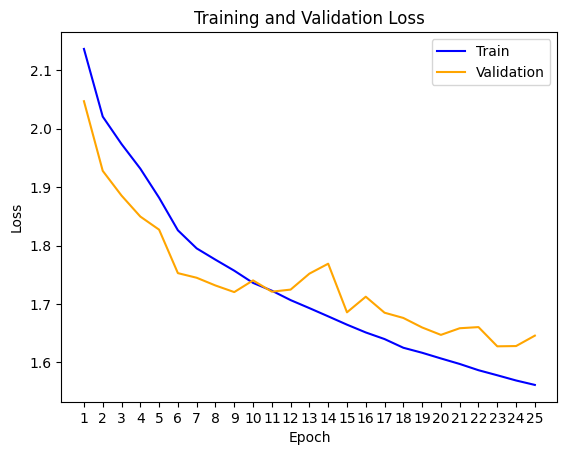

In [ ]:
# visualize loss statistics

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# plot losses
x = list(range(1, n_epoch + 1))
plt.plot(x, train_loss_list, color ="blue", label='Train')
plt.plot(x, valid_loss_list, color="orange", label='Validation')
plt.legend(loc="upper right")
plt.xticks(x)

plt.show()

In [ ]:
# prepare model for evaluation
vision_transformer.eval()

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(classes)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpuhttps://arxiv.org/pdf/1706.03762.pdf
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in test_loader:

    # get outputs
    outputs, _ = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        targets = targets.to('cpu')

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))


Test Loss: 1.575793


In [ ]:
class_accuracy = class_correct / class_total

print('Test Accuracy of Classes')
print()

for c in range(n_class):
    print('{}\t: {}% \t ({}/{})'.format(classes[c],
                                int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )

print()
print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                           int(np.sum(class_correct)), int(np.sum(class_total)) ))

Test Accuracy of Classes

airplane	: 47% 	 (49/103)
automobile	: 52% 	 (47/89)
bird	: 43% 	 (43/100)
cat	: 41% 	 (43/103)
deer	: 23% 	 (21/90)
dog	: 23% 	 (20/86)
frog	: 57% 	 (64/112)
horse	: 25% 	 (26/102)
ship	: 66% 	 (70/106)
truck	: 38% 	 (42/109)

Test Accuracy of Dataset: 	 42% 	 (425/1000)


---
**Vision Transformer Success**

>Vision Transformer (ViT) attains excellent results when pre-trained at sufficient scale and transferred to tasks with fewer datapoints. When pre-trained on the public ImageNet-21k dataset or the in-house JFT-300M dataset, ViT approaches or beats state of the art on multiple image recognition benchmarks. In particular, the best model reaches the accuracy of 88.55% on ImageNet, 90.72% on ImageNet-ReaL, 94.55% on CIFAR-100, and 77.63% on the VTAB suite of 19 tasks. <br>


**Vision Transformer Weakness**

>Transformers lack some of the inductive biases inherent to CNNs, such as translation equivariance and locality, and therefore do not generalize well when trained on insufficient amounts of data. <br>

>**Inductive bias**: We note that Vision Transformer has much less image-specific inductive bias than CNNs. In CNNs, locality, two-dimensional neighborhood structure, and translation equivariance are baked into each layer throughout the whole model. In ViT, only MLP layers are local and translationally equivariant, while the self-attention layers are global. The two-dimensional neighborhood structure is used very sparingly: in the beginning of the model by cutting the image into patches and at fine-tuning time for adjusting the position embeddings for images of different resolution. Other than that, the position embeddings at initialization time carry no information
about the 2D positions of the patches and all spatial relations between the patches have to be learned from scratch. <br>

---

**Final Notes**

The implementation here is a very basic representation of how Vision Transformers work. The code structure here is to preserve the simplicity of the code so that to be easier to follow. There are a lot of improvements that can be made in the implementation and calculations can be further optimized.

---

### References

1.  An Image is Worth 16x16 Words: Transformers For Image Recognition At Scale Paper - https://arxiv.org/pdf/2010.11929.pdf
2. Illustrated Transformer Blog Post - https://jalammar.github.io/illustrated-transformer/
3. Attention is All You Need Paper - https://arxiv.org/pdf/1706.03762.pdf
4. What exactly are keys, queries, and values in attention mechanisms? - https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms

### Additional Resources

1. HuggingFace Implementation: https://huggingface.co/docs/transformers/model_doc/vit
2. Swin Transformer: Hierarchical Vision Transformer using Shifted Windows - https://arxiv.org/pdf/2103.14030.pdf
3. DeiT: Data Efficient Image Transformer - https://arxiv.org/pdf/2012.12877.pdf
4. BEiT: BERT Pre-Training of Image Transformers - https://arxiv.org/pdf/2106.08254.pdf

---
---